In [1]:
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, train_test_split

import os
from glob import glob

from utils.config import save_dict_as_yaml, create_dir_suffix
from utils.preprocessing.numpy import get_idxs_of_annotated_slices
from utils.datasets.foscal.patient import ISLES2022Patient
from utils.datasets.foscal.create_dataset import get_foscal_train_val_test_patients, create_foscal_dataset

2023-05-29 17:04:09.058087: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 17:04:09.106014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helpers

In [2]:
data_dir = "data/"

def resample_volume(volume_path, interpolator=sitk.sitkLinear, new_spacing=[1.0, 1.0, 1.0]):
    volume = sitk.ReadImage(volume_path, sitk.sitkFloat32)
    original_spacing = volume.GetSpacing()
    original_size = volume.GetSize()
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                         volume.GetOrigin(), new_spacing, volume.GetDirection(), 0,
                         volume.GetPixelID())
                         

def get_first_match_for_substring(list_, substring: str):
    """Returns the first element in `list_` that matches."""
    match = None
    for elem in list_:
        if substring in elem:
            match = elem
            break
    return match


def foscal_train_val_test(
    source_dset_dir,
    volumes,
    slices,
    patches,
    z_norm,
    min_max_norm,
):

    check_norm_flags(z_norm, min_max_norm)
    check_spatial_flags(volumes, slices, patches)
    modalities = ["ADC"]

    # Get the patients for each split.
    (
        train_patients_orig,
        train_patients,
        valid_patients,
        test_patients,
    ) = get_foscal_train_val_test_patients(source_dset_dir)

    # Create the directory to store all the data.
    dir_suffix = create_dir_suffix(
        volumes=volumes,
        slices=slices,
        patches=patches,
        z_norm=z_norm,
        min_max_norm=min_max_norm,
    )
    target_dset_dir = os.path.join(data_dir, f"FOSCAL_{dir_suffix}")
    print(f"Created directory for the dataset at: {target_dset_dir}\n")
    os.makedirs(target_dset_dir, exist_ok=True)

    # Create training and validation sets.
    if z_norm:
        normalization = "z"
    elif min_max_norm:
        normalization = "min_max"

    # Create the TFRecords for full_training, training, valid and test.
    tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
    os.makedirs(tfrecords_dir, exist_ok=True)
    full_train_tfrecord_path, num_full_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients_orig,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="full_train",
    )
    train_tfrecord_path, num_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="train",
    )

    # Validation and test metrics are always calculated at volume-level.
    # Hence, serialize volumes to the TFRecords. Test TFRecord is not created
    # because it patients do not have masks. Other script will be used.
    valid_tfrecord_path, num_valid_samples = create_foscal_dataset(
        tfrecords_dir,
        valid_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="valid",
    )

    # Save the patient paths to the dataset dir.
    patients_dir = os.path.join(target_dset_dir, "patients")
    os.makedirs(patients_dir, exist_ok=True)
    full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
    train_patients_path = os.path.join(patients_dir, "train_patients.txt")
    valid_patients_path = os.path.join(patients_dir, "valid_patients.txt")
    test_patients_path = os.path.join(patients_dir, "test_patients.txt")
    np.savetxt(full_train_patients_path, train_patients_orig, fmt="%s")
    np.savetxt(train_patients_path, train_patients, fmt="%s")
    np.savetxt(valid_patients_path, valid_patients, fmt="%s")
    np.savetxt(test_patients_path, test_patients, fmt="%s")

    # Save dataset configuration as YAML file.
    dset_config = {
        "dset_name": "FOSCAL",
        "normalization": normalization,
        "full_train_tfrecord": get_path_and_parent_dir(full_train_tfrecord_path),
        "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
        "valid_tfrecord": get_path_and_parent_dir(valid_tfrecord_path),
        "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
        "train_patients_path": get_path_and_parent_dir(train_patients_path),
        "valid_patients_path": get_path_and_parent_dir(valid_patients_path),
        "test_patients_path": get_path_and_parent_dir(test_patients_path),
        "num_full_train_samples": num_full_train_samples,
        "num_train_samples": num_train_samples,
        "num_valid_samples": num_valid_samples,
        "modalities": modalities,
    }
    dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
    save_dict_as_yaml(dset_config_path, dset_config)


def check_norm_flags(z_norm: bool, min_max_norm: bool):
    """Normalization argument testing: Check if only one argument
    was marked"""
    if z_norm and min_max_norm:
        raise ValueError(
            "Both z_norm and min_max_norm are True. Only one could "
            "be True per execution."
        )
    elif (not z_norm) and (not min_max_norm):
        raise ValueError(
            "Both z_norm and min_max_norm are False. One of them should True."
        )


def check_spatial_flags(volumes: bool, slices: bool, patches: bool):
    """Dataset type argument testing: Raise an exception if
    the user marked two or more modes."""
    if volumes and slices and patches:
        raise ValueError(
            "All the arguments were set to True. Only one of volumes"
            " slices and patches should be True per execution"
        )
    elif not (volumes ^ slices ^ patches):
        raise ValueError(
            "Set one, and only one, argument of volumes, slices and " "patches to True."
        )


def get_path_and_parent_dir(path: str) -> str:
    """Return only the parent dir and filename of a path

    e.g. 'dir/dir2/dir3/filename.txt' -> 'dir3/filename.txt'
    """
    return "/".join(path.split("/")[-2:])

# ISLES2022 dataset for MICCAI rebuttal

ISLES22 cases with pixel spacing different to 2mm isotropic.

```python
patient_ids_with_different_spacing = [
    sub-strokecase0046, sub-strokecase0052, sub-strokecase0060, sub-strokecase0073, sub-strokecase0101, sub-strokecase0102
    sub-strokecase0105, sub-strokecase0122, sub-strokecase0137, sub-strokecase0153, sub-strokecase0154, sub-strokecase0155
    sub-strokecase0157, sub-strokecase0159, sub-strokecase0161, sub-strokecase0162, sub-strokecase0164, sub-strokecase0165
    sub-strokecase0166, sub-strokecase0167, sub-strokecase0175, sub-strokecase0176, sub-strokecase0182, sub-strokecase0184
    sub-strokecase0185, sub-strokecase0186, sub-strokecase0187, sub-strokecase0188, sub-strokecase0189, sub-strokecase0191
    sub-strokecase0192, sub-strokecase0193, sub-strokecase0194, sub-strokecase0195, sub-strokecase0197, sub-strokecase0198
    sub-strokecase0199, sub-strokecase0200, sub-strokecase0201, sub-strokecase0202, sub-strokecase0206, sub-strokecase0207
    sub-strokecase0208, sub-strokecase0209, sub-strokecase0210, sub-strokecase0215, sub-strokecase0216, sub-strokecase0219
    sub-strokecase0222, sub-strokecase0224, sub-strokecase0226, sub-strokecase0227, sub-strokecase0228, sub-strokecase0229
    sub-strokecase0230, sub-strokecase0232, sub-strokecase0236, sub-strokecase0238, sub-strokecase0239, sub-strokecase0240
    sub-strokecase0241, sub-strokecase0243, sub-strokecase0245, sub-strokecase0248, sub-strokecase0249, sub-strokecase0250
]
```

In [3]:
from utils.datasets.isles2022.create_dataset import create_isles2022_dataset

isles22_dir = '/data/stroke/ISLES2022/'
patient_ids = sorted(os.listdir(os.path.join(isles22_dir, 'rawdata')))

## Resampling

Resample all cases to 2mm isotropic spacing and store them in a `resampled` directory inside `rawdata` and `derivatives`.

In [ ]:
for patient_id in patient_ids:
    patient = ISLES2022Patient(isles22_dir, patient_id)

    # Resample to 2mm isotropic, 1mm resulted in blurred images. Also, didnt include flair because of different size.
    resampled_data_dir = os.path.join(os.path.dirname(patient.adc_path), 'resampled')
    os.makedirs(resampled_data_dir, exist_ok=True)

    patient_adc_res = resample_volume(patient.adc_path, interpolator=sitk.sitkLinear, new_spacing=[2.0, 2.0, 2.0])
    adc_resampled_filename = os.path.basename(patient.adc_path).replace('adc.nii.gz', 'adc_resampled.nii.gz')
    adc_resampled_path = os.path.join(resampled_data_dir, adc_resampled_filename)
    sitk.WriteImage(patient_adc_res, adc_resampled_path)

    patient_dwi_res = resample_volume(patient.dwi_path, interpolator=sitk.sitkLinear, new_spacing=[2.0, 2.0, 2.0])
    dwi_resampled_filename = os.path.basename(patient.dwi_path).replace('dwi.nii.gz', 'dwi_resampled.nii.gz')
    dwi_resampled_path = os.path.join(resampled_data_dir, dwi_resampled_filename)
    sitk.WriteImage(patient_dwi_res, dwi_resampled_path)

    # Do the same for the mask.
    resampled_derivatives_dir = os.path.join(os.path.dirname(patient.mask_path), 'resampled')
    os.makedirs(resampled_derivatives_dir, exist_ok=True)

    patient_mask_res = resample_volume(patient.mask_path, interpolator=sitk.sitkLinear, new_spacing=[2.0, 2.0, 2.0])
    mask_resampled_filename = os.path.basename(patient.mask_path).replace('msk.nii.gz', 'msk_resampled.nii.gz')
    mask_resampled_path = os.path.join(resampled_derivatives_dir, mask_resampled_filename)
    sitk.WriteImage(patient_mask_res, mask_resampled_path)

## Dataset

### Hyperparameters

In [4]:
volumes = False
slices = True
patches = False
z_norm = False
min_max_norm = True
modalities = ["ADC", "DWI"]

### 5-fold cross-validation

In [7]:
# patient_dirs = glob(os.path.join(dset_dir, "*"))
# patient_dirs = np.array(patient_dirs)

isles22_dir = '/data/stroke/ISLES2022/'
patient_ids = sorted(os.listdir(os.path.join(isles22_dir, 'rawdata')))
patient_ids = np.array(patient_ids)

kf = KFold(shuffle=True, random_state=2431)
for i, (train_index, test_index) in enumerate(kf.split(patient_ids)):
    
    full_train_patients = patient_ids[train_index]
    test_patients = patient_ids[test_index]
    # ! supervisor suggested to not split the training set.
    # Split the training set into training and validation to have a stop criterion.
    # train_patients, valid_patients = train_test_split(
    #     full_train_patients, test_size=0.2, random_state=2431
    # )

    # ! delete.
    # train_patients = train_patients[:2]
    # valid_patients = valid_patients[:2]
    # test_patients = test_patients[:2]

    # Create the directory to store all the data.
    dir_suffix = create_dir_suffix(
        volumes=volumes,
        slices=slices,
        patches=patches,
        z_norm=z_norm,
        min_max_norm=min_max_norm,
    )

    # Create the directory for each fold.
    target_dset_dir = os.path.join(data_dir, f"ISLES2022_{dir_suffix}", f"fold_{i}")
    print(f"Created directory for the dataset at: {target_dset_dir}\n")
    os.makedirs(target_dset_dir, exist_ok=True)

    # Create training and validation sets.
    if z_norm:
        normalization = "z"
    elif min_max_norm:
        normalization = "min_max"

    # # Create the TFRecords for full_training, training, valid and test.
    tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
    os.makedirs(tfrecords_dir, exist_ok=True)

    train_tfrecord_path, num_train_samples = create_isles2022_dataset(
        tfrecords_dir,
        full_train_patients,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="train",
    )

    # Validation and test metrics are always calculated at volume-level.
    # Hence, serialize volumes to the TFRecords. Test TFRecord is not created
    # because it patients do not have masks. Other script will be used.
    valid_tfrecord_path, num_valid_samples = create_isles2022_dataset(
        tfrecords_dir,
        test_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="valid",
    )

    test_tfrecord_path, num_test_samples = create_isles2022_dataset(
        tfrecords_dir,
        test_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="test",
    )

    # Save the patient paths to the dataset dir.
    patients_dir = os.path.join(target_dset_dir, "patients")
    os.makedirs(patients_dir, exist_ok=True)
    full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
    train_patients_path = os.path.join(patients_dir, "train_patients.txt")
    valid_patients_path = os.path.join(patients_dir, "valid_patients.txt")
    test_patients_path = os.path.join(patients_dir, "test_patients.txt")
    np.savetxt(full_train_patients_path, full_train_patients, fmt="%s")
    np.savetxt(train_patients_path, full_train_patients, fmt="%s")
    np.savetxt(valid_patients_path, test_patients, fmt="%s")
    np.savetxt(test_patients_path, test_patients, fmt="%s")

    # Save dataset configuration as YAML file.
    dset_config = {
        "dset_name": "ISLES2022",
        "normalization": normalization,
        "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
        "valid_tfrecord": get_path_and_parent_dir(valid_tfrecord_path),
        "test_tfrecord": get_path_and_parent_dir(test_tfrecord_path),
        "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
        "train_patients_path": get_path_and_parent_dir(train_patients_path),
        "valid_patients_path": get_path_and_parent_dir(valid_patients_path),
        "test_patients_path": get_path_and_parent_dir(test_patients_path),
        "num_train_samples": num_train_samples,
        "num_test_samples": num_test_samples,
        "modalities": modalities,
    }
    dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
    save_dict_as_yaml(dset_config_path, dset_config)


Created directory for the dataset at: data/ISLES2022_slices_min_max_norm/fold_0



Creating test dataset: 100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


Created directory for the dataset at: data/ISLES2022_slices_min_max_norm/fold_1



Creating test dataset: 100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


Created directory for the dataset at: data/ISLES2022_slices_min_max_norm/fold_2



Creating test dataset: 100%|██████████| 50/50 [00:04<00:00, 11.57it/s]


Created directory for the dataset at: data/ISLES2022_slices_min_max_norm/fold_3



Creating test dataset: 100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


Created directory for the dataset at: data/ISLES2022_slices_min_max_norm/fold_4



Creating test dataset: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


### Verify the TFRecords were created correctly

In [5]:
from dataloader import TFSlicesDataloader, TFSlicesValidationDataloader

train_dataloader = TFSlicesDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/ISLES2022_slices_min_max_norm/fold_0/tfrecords/train.tfrecord",
    modalities=modalities,
    slice_size=112,
    batch_size=32,
    deep_supervision=False,
    num_lods=4,
    augmentations=True,
    sample_weights=True,
    class_weights=[1.0, 3.0],
    cache=False,
    prefetch=False,
    shuffle_buffer=0
)

test_dataloader = TFSlicesValidationDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/ISLES2022_slices_min_max_norm/fold_0/tfrecords/valid.tfrecord",
    modalities=modalities,
    slice_size=112,
    deep_supervision=False,
    num_lods=4,
    cache=False,
    prefetch=False
)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-29 00:41:23.889320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2023-05-29 00:41:23.889361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 1660b6c49a51
2023-05-29 00:41:23.889367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 1660b6c49a51
2023-05-29 00:41:23.889477: I t

2023-05-29 00:41:29.517517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-29 00:41:29.517896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


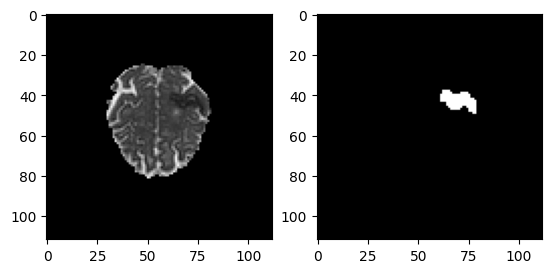

In [6]:
train_set = train_dataloader.get_dataset()
for batch in train_set.take(2):
    pass

plt.subplot(1, 2, 1)
plt.imshow(batch[0][27, :, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(batch[1][27, :, :, 0], cmap="gray")

# Hyperparameters

In [3]:
volumes = False
slices = True
patches = False
z_norm = False
min_max_norm = True
modalities = ["ADC", "DWI"]

# Create a train-test split

In [4]:
normal_train_patients = ["ACV-107", "ACV-110", "ACV-128", "ACV-129", "ACV-140"]

dset_dir = "/data/Datasets/stroke/MICCAI/"
train_dir = os.path.join(dset_dir, "train")
full_train_patients = sorted(glob(os.path.join(train_dir, "*")))
train_patients, valid_patients = train_test_split(
    full_train_patients, test_size=0.2, random_state=4
)

test_dir = os.path.join(dset_dir, "test")
test_patients = sorted(glob(os.path.join(test_dir, "*")))

set([os.path.basename(p) for p in valid_patients]).intersection(normal_train_patients)

{'ACV-129'}

Create the dataset

In [5]:
# Create the directory to store all the data.
dir_suffix = create_dir_suffix(
    volumes=volumes,
    slices=slices,
    patches=patches,
    z_norm=z_norm,
    min_max_norm=min_max_norm,
)

# Create the directory for each fold.
target_dset_dir = os.path.join(data_dir, f"FOSCAL_{dir_suffix}", f"train_val")
print(f"Created directory for the dataset at: {target_dset_dir}\n")
os.makedirs(target_dset_dir, exist_ok=True)

# Create training and validation sets.
if z_norm:
    normalization = "z"
elif min_max_norm:
    normalization = "min_max"

# Create the TFRecords for full_training, training, valid and test.
tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
os.makedirs(tfrecords_dir, exist_ok=True)

train_tfrecord_path, num_train_samples = create_foscal_dataset(
    tfrecords_dir,
    train_patients,
    volumes=volumes,
    slices=slices,
    patches=patches,
    normalization=normalization,
    modalities=modalities,
    dset_split="train",
)

# Validation and test metrics are always calculated at volume-level.
# Hence, serialize volumes to the TFRecords. Test TFRecord is not created
# because it patients do not have masks. Other script will be used.
valid_tfrecord_path, num_valid_samples = create_foscal_dataset(
    tfrecords_dir,
    valid_patients,
    volumes=True,
    slices=False,
    patches=False,
    normalization=normalization,
    modalities=modalities,
    dset_split="valid",
)

# Save the patient paths to the dataset dir.
patients_dir = os.path.join(target_dset_dir, "patients")
os.makedirs(patients_dir, exist_ok=True)
full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
train_patients_path = os.path.join(patients_dir, "train_patients.txt")
valid_patients_path = os.path.join(patients_dir, "valid_patients.txt")
test_patients_path = os.path.join(patients_dir, "test_patients.txt")
np.savetxt(train_patients_path, train_patients, fmt="%s")
np.savetxt(valid_patients_path, valid_patients, fmt="%s")
np.savetxt(test_patients_path, test_patients, fmt="%s")

# Save dataset configuration as YAML file.
dset_config = {
    "dset_name": "FOSCAL",
    "normalization": normalization,
    "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
    "valid_tfrecord": get_path_and_parent_dir(valid_tfrecord_path),
    "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
    "train_patients_path": get_path_and_parent_dir(train_patients_path),
    "valid_patients_path": get_path_and_parent_dir(valid_patients_path),
    "test_patients_path": get_path_and_parent_dir(test_patients_path),
    "num_train_samples": num_train_samples,
    "num_valid_samples": num_valid_samples,
    "modalities": modalities,
}
dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
save_dict_as_yaml(dset_config_path, dset_config)

Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/train_val



Creating train dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:   2%|▎         | 1/40 [00:02<01:20,  2.06s/it]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:   5%|▌         | 2/40 [00:04<01:18,  2.07s/it]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  10%|█         | 4/40 [00:05<00:47,  1.32s/it]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  12%|█▎        | 5/40 [00:06<00:32,  1.07it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  15%|█▌        | 6/40 [00:09<00:57,  1.68s/it]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  20%|██        | 8/40 [00:09<00:28,  1.13it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  22%|██▎       | 9/40 [00:10<00:28,  1.09it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  32%|███▎      | 13/40 [00:13<00:14,  1.88it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  35%|███▌      | 14/40 [00:13<00:11,  2.31it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  48%|████▊     | 19/40 [00:14<00:06,  3.02it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  62%|██████▎   | 25/40 [00:20<00:22,  1.48s/it]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  88%|████████▊ | 35/40 [00:27<00:04,  1.05it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating train dataset:  90%|█████████ | 36/40 [00:27<00:02,  1.36it/s]

Could not found DWI mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset:   0%|          | 0/11 [00:00<?, ?it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset:   9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset:  18%|█▊        | 2/11 [00:00<00:03,  2.75it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset:  45%|████▌     | 5/11 [00:01<00:01,  3.11it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset:  55%|█████▍    | 6/11 [00:01<00:01,  3.33it/s]

Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.
Could not found ADC mask for Daniel.
Could not found DWI mask for Daniel.


Creating valid dataset: 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


# Create the folds for the experiments

Create the 5-fold dataset

In [4]:
# Identify the normal patients.
normal_train_patients = ["ACV-107", "ACV-110", "ACV-128", "ACV-129", "ACV-140"]
normal_test_patients = ["ACV-149", "ACV-198"]

dset_dir = "/data/Datasets/stroke/MICCAI/"
train_dir = os.path.join(dset_dir, "train")
train_patients_dirs = glob(os.path.join(train_dir, "*"))
train_patients_dirs = np.array(train_patients_dirs)

test_dir = os.path.join(dset_dir, "test")
test_patients_dirs = glob(os.path.join(test_dir, "*"))
test_patients_dirs = np.array(test_patients_dirs)


train_patients = [os.path.basename(p) for p in train_patients_dirs]
test_patients = [os.path.basename(p) for p in test_patients_dirs]
print("Train:", set(normal_train_patients).difference(train_patients))
print("Test:", set(normal_test_patients).difference(test_patients))

Train: set()
Test: set()


In [7]:
len(train_patients_dirs), len(test_patients_dirs)

(53, 31)

In [ ]:
os.makedirs("folds", exist_ok=True)
dset_dir = "/data/Datasets/stroke/MICCAI/train/"
patient_dirs = glob(os.path.join(dset_dir, "*"))
patient_dirs = np.array(patient_dirs)

kf = KFold(shuffle=True, random_state=3)
for i, (train_index, test_index) in enumerate(kf.split(patient_dirs)):
    
    train_patients = patient_dirs[train_index]
    test_patients = patient_dirs[test_index]
    save_dict_as_yaml(
        f"folds/fold_{i}_patients.yml", 
        {
            "train": train_patients.tolist(), 
            "test": test_patients.tolist()
        }
    )

    # Create the directory to store all the data.
    dir_suffix = create_dir_suffix(
        volumes=volumes,
        slices=slices,
        patches=patches,
        z_norm=z_norm,
        min_max_norm=min_max_norm,
    )

    # Create the directory for each fold.
    target_dset_dir = os.path.join(data_dir, f"FOSCAL_{dir_suffix}", f"fold_{i}")
    print(f"Created directory for the dataset at: {target_dset_dir}\n")
    os.makedirs(target_dset_dir, exist_ok=True)

    # Create training and validation sets.
    if z_norm:
        normalization = "z"
    elif min_max_norm:
        normalization = "min_max"

    # Create the TFRecords for full_training, training, valid and test.
    tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
    os.makedirs(tfrecords_dir, exist_ok=True)

    train_tfrecord_path, num_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="train",
    )

    # Validation and test metrics are always calculated at volume-level.
    # Hence, serialize volumes to the TFRecords. Test TFRecord is not created
    # because it patients do not have masks. Other script will be used.
    test_tfrecord_path, num_test_samples = create_foscal_dataset(
        tfrecords_dir,
        test_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="test",
    )

    # Save the patient paths to the dataset dir.
    patients_dir = os.path.join(target_dset_dir, "patients")
    os.makedirs(patients_dir, exist_ok=True)
    full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
    train_patients_path = os.path.join(patients_dir, "train_patients.txt")
    test_patients_path = os.path.join(patients_dir, "test_patients.txt")
    np.savetxt(train_patients_path, train_patients, fmt="%s")
    np.savetxt(test_patients_path, test_patients, fmt="%s")

    # Save dataset configuration as YAML file.
    dset_config = {
        "dset_name": "FOSCAL",
        "normalization": normalization,
        "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
        "test_tfrecord": get_path_and_parent_dir(test_tfrecord_path),
        "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
        "train_patients_path": get_path_and_parent_dir(train_patients_path),
        "test_patients_path": get_path_and_parent_dir(test_patients_path),
        "num_train_samples": num_train_samples,
        "num_test_samples": num_test_samples,
        "modalities": modalities,
    }
    dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
    save_dict_as_yaml(dset_config_path, dset_config)


In [22]:
import nibabel as nib
# {'ADC': (568, 455), 'DWI': (256, 256), 
# 'ADC_mask': (568, 455), 'DWI_mask': (568, 455), 
# 'ADC_mask_with_contours': (568, 455), 'DWI_mask_with_contours': (568, 455)}
print(nib.load('/data/Datasets/stroke/MICCAI/train/ACV-002/2021-11-29-ADC/ADC.nii.gz').shape)
print(nib.load('/data/Datasets/stroke/MICCAI/train/ACV-002/2021-11-29-Ax DWI B-1000/DWI.nii.gz').shape)
print(nib.load('/data/Datasets/stroke/MICCAI/train/ACV-002/Masks/Andres/ADC.nii.gz').shape)
print(nib.load('/data/Datasets/stroke/MICCAI/train/ACV-002/Masks/Andres/DWI.nii.gz').shape)
print(nib.load('/data/Datasets/stroke/ISBI_FOSCAL/ACV-002/2021-11-29-Ax DWI B-1000/Ax_DWI_B-1000_CEREBRAL-PERDIDA_NM_20211129221948_4.nii.gz').shape)
print(nib.load('Ax_DWI_B-1000_CEREBRAL-PERDIDA_NM_20211129221948_4.nii.gz').shape)
os.listdir('/data/Datasets/stroke/ISBI_FOSCAL/ACV-002/2021-11-29-Ax DWI B-1000/')

(568, 455, 26)
(256, 256, 26, 2)
(568, 455, 26)
(568, 455, 26)
(256, 256, 26, 2)
(256, 256, 26, 2)


['Ax_DWI_B-1000_CEREBRAL-PERDIDA_NM_20211129221948_4.nii.gz']

# Test you're able to load the created datasets

In [6]:
from dataloader import TFSlicesDataloader, TFSlicesValidationDataloader
train_dataloader = TFSlicesDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/FOSCAL_slices_min_max_norm/train_val/tfrecords/train.tfrecord",
    modalities=modalities,
    slice_size=224,
    batch_size=32,
    deep_supervision=False,
    num_lods=4,
    augmentations=True,
    sample_weights=True,
    class_weights=[1.0, 3.0],
    cache=False,
    prefetch=False,
    shuffle_buffer=0
)

test_dataloader = TFSlicesValidationDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/FOSCAL_slices_min_max_norm/train_val/tfrecords/valid.tfrecord",
    modalities=modalities,
    slice_size=224,
    deep_supervision=False,
    num_lods=4,
    cache=False,
    prefetch=False
)

# Plot some samples to validate the data pipeline

## Train dataset

In [7]:
train_dset = train_dataloader.get_dataset()
for x_train, y_train, z_train in train_dset.take(1):
    if isinstance(x_train, tuple):
        for i in range(len(x_train)):
            print(f"{modalities[i]} shape: {x_train[i].shape}")
    if isinstance(y_train, tuple):
        for i in range(len(y_train)):
            print(f"{modalities[i]} mask shape: {y_train[i].shape}")
    if isinstance(z_train, tuple):
        for i in range(len(z_train)):
            print(f"{modalities[i]} mask weights shape: {z_train[i].shape}")

ADC shape: (32, 224, 224, 1)
DWI shape: (32, 224, 224, 1)
ADC mask shape: (32, 224, 224, 1)
DWI mask shape: (32, 224, 224, 1)
ADC mask weights shape: (32, 224, 224, 1)
DWI mask weights shape: (32, 224, 224, 1)


### ADC

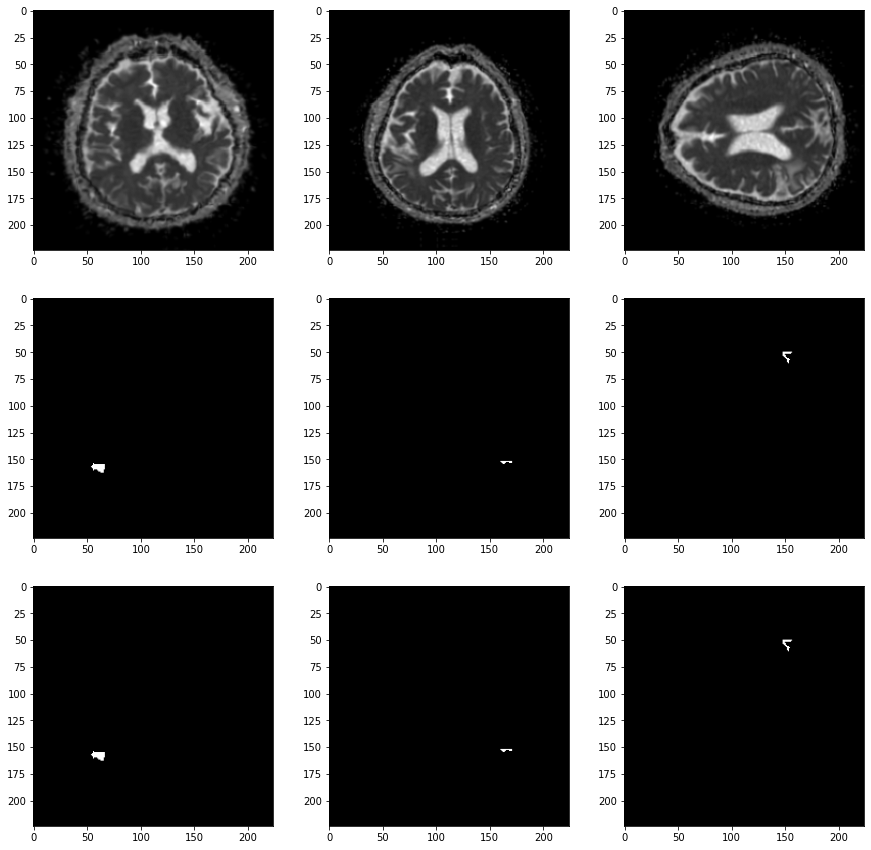

In [8]:
sample_mask = y_train[0].numpy()[..., 0]
sample_adc = x_train[0].numpy()[..., 0]
sample_mask_weights = z_train[0].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_adc = sample_adc[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]
annotated_sample_mask_weights = sample_mask_weights[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(3, num_slices, figsize=(5 * num_slices, 15))
for i in range(num_slices):
    axs[0, i].imshow(annotated_sample_adc[i], cmap="gray")
    axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    axs[2, i].imshow(annotated_sample_mask_weights[i], cmap="gray")


### DWI

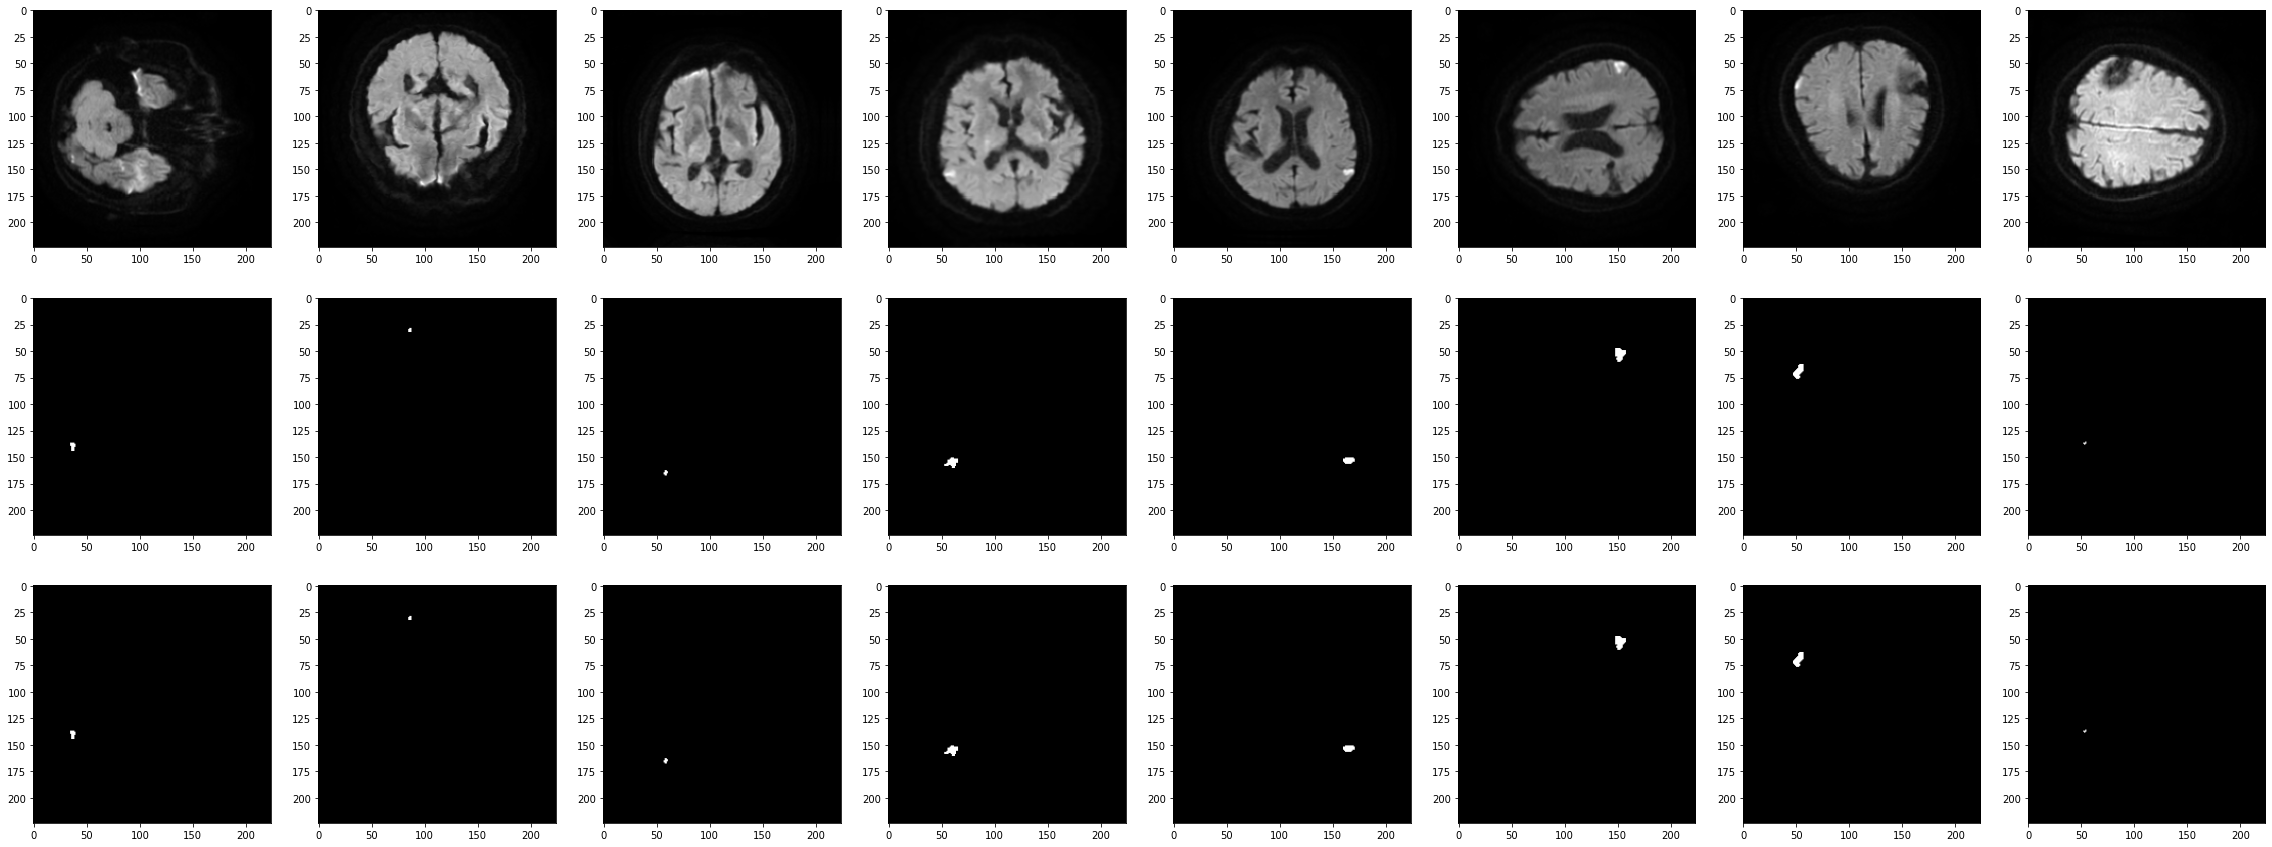

In [9]:
sample_dwi = x_train[1].numpy()[..., 0]
sample_mask = y_train[1].numpy()[..., 0]
sample_mask_weights = z_train[1].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_dwi = sample_dwi[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]
annotated_sample_mask_weights = sample_mask_weights[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(3, num_slices, figsize=(5 * num_slices, 15))
for i in range(num_slices):
    axs[0, i].imshow(annotated_sample_dwi[i], cmap="gray")
    axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    axs[2, i].imshow(annotated_sample_mask_weights[i], cmap="gray")

## Test dataset

In [10]:
test_dset = test_dataloader.get_dataset()
for x_test, y_test in test_dset.take(2):
    if isinstance(x_test, tuple):
        for i in range(len(x_test)):
            print(f"{modalities[i]} shape: {x_test[i].shape}")
    if isinstance(y_test, tuple):
        for i in range(len(y_test)):
            print(f"{modalities[i]} mask shape: {y_test[i].shape}")

ADC shape: (24, 224, 224, 1)
DWI shape: (24, 224, 224, 1)
ADC mask shape: (24, 224, 224, 1)
DWI mask shape: (24, 224, 224, 1)
ADC shape: (26, 224, 224, 1)
DWI shape: (26, 224, 224, 1)
ADC mask shape: (26, 224, 224, 1)
DWI mask shape: (26, 224, 224, 1)


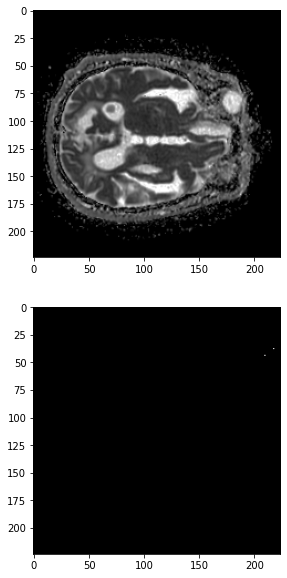

In [11]:
sample_adc = x_test[0].numpy()[..., 0]
sample_mask = y_test[0].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_adc = sample_adc[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(2, num_slices, figsize=(5 * num_slices, 10))
for i in range(num_slices):
    if num_slices > 1:
        axs[0, i].imshow(annotated_sample_adc[i], cmap="gray")
        axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    else:
        axs[0].imshow(annotated_sample_adc[i], cmap="gray")
        axs[1].imshow(annotated_sample_mask[i], cmap="gray")
